In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy
import arviz as az
import pymc3 as pm
from tqdm import tqdm
import theano
import theano.tensor as tt
import pandas as pd
import datetime

In [2]:
from tools import *
from existing import Regeneration_Model
from model import Convolution
from utils import DataReader

In [3]:
theano.config.floatX= 'float64'
az.style.use("arviz-darkgrid")

In [4]:
it_covid19_csv = "dataset/IT_COVID19.csv"
it_covid19_df = pd.read_csv(it_covid19_csv)
it_policy_csv = "dataset/IT_Policy.csv"
it_policy_df = pd.read_csv(it_policy_csv)

In [5]:
d = DataReader("IT", it_covid19_df, it_policy_df)
d.start_date = datetime.date(2020, 2, 20)
d.end_date = datetime.date(2020, 5, 1)
fit_start_date = datetime.datetime.strptime(d.start_date, "%Y-%m-%d").date()
fit_end_date = datetime.date(2020, 4, 13)
fit_ndays = (fit_end_date - fit_start_date).days + 1

In [6]:
Id_covid19_series = d.confirmed_cases_new
Rd_covid19_series = d.recovered_cases_new
Dd_covid19_series = d.deaths_cases_new
policy_series = d.policy_series

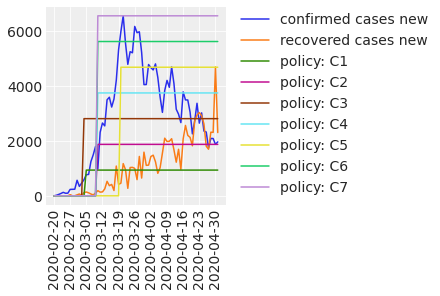

In [7]:
d.plot()

In [8]:
policy_series = []
policy_series_ood_1 = []
policy_series_ood_2 = []
policy_series_ood_3 = []
change_point1 = (datetime.date(2020, 3, 3) - datetime.date(2020, 2, 20)).days + 1
change_point2 = (datetime.date(2020, 3, 9) - datetime.date(2020, 2, 20)).days + 1
change_point3 = (datetime.date(2020, 3, 19) - datetime.date(2020, 2, 20)).days + 1
for i in range(change_point1):
    policy_series_ood_3.append([0, 0, 0])
    policy_series_ood_2.append([0, 0, 0])
    policy_series_ood_1.append([0, 0, 0])
    policy_series.append([0, 0, 0])
    pass
for i in range(change_point2-change_point1):
    policy_series_ood_3.append([0, 0, 0])
    policy_series_ood_2.append([1, 0, 0])
    policy_series_ood_1.append([1, 0, 0])
    policy_series.append([1, 0, 0])
    pass
for i in range(change_point3-change_point2):
    policy_series_ood_3.append([0, 0, 0])
    policy_series_ood_2.append([1, 0, 0])
    policy_series_ood_1.append([0, 1, 0])
    policy_series.append([0, 1, 0])
    pass
for i in range(len(d.dates)-change_point3):
    policy_series_ood_3.append([0, 0, 0])
    policy_series_ood_2.append([1, 0, 0])
    policy_series_ood_1.append([0, 1, 0])
    policy_series.append([0, 0, 1])
    pass
print(np.array(policy_series).shape)

(72, 3)


In [9]:
with pm.Model() as model:
    
    n_steps = len(d.dates)
    
    N = 5944e4
    
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
    
    # layer 0
    mu, sigma = LogNormalParams(250, 50)
    N0 = pm.LogNormal(r'$N_{\alpha_{0}}$', mu=mu, sigma=sigma)
    i0 = tt.constant(np.array(1, dtype=np.float64))
    S0t = N0 - i0
    
    lambda0 = PositiveNormal(r'$\lambda_{\alpha_{0}}$', mu=1.32, sigma=0.1)
    t = tt.constant(np.float64([i for i in range(n_steps)]))
    G0t = lambda0 * np.exp(1) ** -(lambda0 * t)
    G0t = G0t / tt.sum(G0t)
    
    R0 = PositiveNormal(r"$R_{0,\alpha_{0}}$", mu=1.25, sigma=0.01)
    
    i0t_history = tt.concatenate([tt.reshape(i0, newshape=(1,)), \
                                  tt.constant(np.zeros((n_steps-1,), dtype=np.float64))], axis=0)
    
    policy_weights_0 = tt.constant(np.zeros(np.array(policy_series).shape[-1], dtype=np.float64))
    
    _1, _2, i0t, I0t, I0tc, R0t = \
    Regeneration_Model(R0, G0t, S0t, i0t_history, N0, policy_series, policy_weights_0)
    i0t_ = pm.Deterministic(r'$i_{\alpha_{0},0}(t)$', i0t)
    
    # layer 1
    N1 = N / N0
    k1 = PositiveNormal(r"$k_{s,\alpha_{1}}$", mu=0.055, sigma=0.005)
    
    G1t = I0t
    
    mu, sigma = LogNormalParams(270, 50)
    i1 = pm.LogNormal(name=r"$i_{0s,\alpha_{1}}$", mu=mu, sigma=sigma)
    S1t = N1 - i1
    
    i1t_history = tt.concatenate([tt.reshape(i1, newshape=(1,)), \
                                  tt.constant(np.zeros((n_steps-1,), dtype=np.float64))], axis=0)
    
    change_k1_1 = pm.Uniform(r"Change in $k_{s,\alpha_{1}}$ on March 3, 2020", \
                             lower=-0.05, upper=k1)
    change_k1_1 = tt.reshape(change_k1_1, newshape=(1,))
    change_k1_2 = pm.Uniform(r"Change in $k_{s,\alpha_{1}}$ on March 9, 2020", \
                             lower=-0.05, upper=k1)
    change_k1_2 = tt.reshape(change_k1_2, newshape=(1,))
    change_k1_3 = pm.Uniform(r"Change in $k_{s,\alpha_{1}}$ on March 19, 2020", \
                             lower=-0.05, upper=k1)
    change_k1_3 = tt.reshape(change_k1_3, newshape=(1,))
    policy_weights_1 = tt.concatenate([change_k1_1, change_k1_2, change_k1_3], axis=0)
    
    _1, _2, i1t, I1t, I1tc, k1t = \
    Regeneration_Model(k1, G1t, S1t, i1t_history, N1, policy_series, policy_weights_1)
    i1t_ = pm.Deterministic(r'$i_{s,\alpha_{1},0}(t)$', i1t)
    k1t_ = pm.Deterministic(r'$k_{s,\alpha_{1}}(t)$', k1t)
    
    it = Convolution(i0t, i1t)
    it = pm.Deterministic(r'$i(t)$', it[0:n_steps])
    
    # OOD 1
    _1, _2, i1t_ood_1, I1t_ood_1, I1tc_ood_1, k1t_ood_1 = \
    Regeneration_Model(k1, G1t, S1t, i1t_history, N1, policy_series_ood_1, policy_weights_1)
    i1t_ood_1_ = pm.Deterministic(r'$i_{s,\alpha_{1},0}(t)$OOD1', i1t_ood_1)
    k1t_ood_1_ = pm.Deterministic(r'$k_{s,\alpha_{1}}(t)$OOD1', k1t_ood_1)
    
    it_ood_1 = Convolution(i0t, i1t_ood_1)
    it_ood_1 = pm.Deterministic(r'$i(t)$OOD1', it_ood_1[0:n_steps])
    
    # OOD 2
    _1, _2, i1t_ood_2, I1t_ood_2, I1tc_ood_2, k1t_ood_2 = \
    Regeneration_Model(k1, G1t, S1t, i1t_history, N1, policy_series_ood_2, policy_weights_1)
    i1t_ood_2_ = pm.Deterministic(r'$i_{s,\alpha_{1},0}(t)$OOD2', i1t_ood_2)
    k1t_ood_2_ = pm.Deterministic(r'$k_{s,\alpha_{1}}(t)$OOD2', k1t_ood_2)
    
    it_ood_2 = Convolution(i0t, i1t_ood_2)
    it_ood_2 = pm.Deterministic(r'$i(t)$OOD2', it_ood_2[0:n_steps])
    
    # OOD 3
    _1, _2, i1t_ood_3, I1t_ood_3, I1tc_ood_3, k1t_ood_3 = \
    Regeneration_Model(k1, G1t, S1t, i1t_history, N1, policy_series_ood_3, policy_weights_1)
    i1t_ood_3_ = pm.Deterministic(r'$i_{s,\alpha_{1},0}(t)$OOD3', i1t_ood_3)
    k1t_ood_3_ = pm.Deterministic(r'$k_{s,\alpha_{1}}(t)$OOD3', k1t_ood_3)
    
    it_ood_3 = Convolution(i0t, i1t_ood_3)
    it_ood_3 = pm.Deterministic(r'$i(t)$OOD3', it_ood_3[0:n_steps])
    
    eps = pm.HalfNormal(r'$\varepsilon_{i(t)}$')
    obs_fit = pm.Normal(r'Fit', mu=it[:fit_ndays], sigma=eps*it[:fit_ndays], shape=(len(Id_covid19_series[:fit_ndays])), \
                        observed=Id_covid19_series[:fit_ndays])  
    obs_forecast = pm.Deterministic(r'Forecast', it[fit_ndays:])
    
    step1 = pm.Metropolis(vars=[it])
    step2 = pm.Slice(vars=[eps])
    trace = pm.sample(4000, cores=4, chains=4, tune=6000, step=[step1, step2], init='advi', \
                      return_inferencedata=True)
    pass    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [$N_{\alpha_{0}}$]
>>Metropolis: [$R_{0,\alpha_{0}}$]
>>Metropolis: [$\lambda_{\alpha_{0}}$]
>>Metropolis: [$i_{0s,\alpha_{1}}$]
>>Metropolis: [Change in $k_{s,\alpha_{1}}$ on March 3, 2020]
>>Metropolis: [$k_{s,\alpha_{1}}$]
>>Metropolis: [Change in $k_{s,\alpha_{1}}$ on March 9, 2020]
>>Metropolis: [Change in $k_{s,\alpha_{1}}$ on March 19, 2020]
>Slice: [$\varepsilon_{i(t)}$]


Sampling 4 chains for 6_000 tune and 4_000 draw iterations (24_000 + 16_000 draws total) took 444 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\plots\traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  warnings.warn(


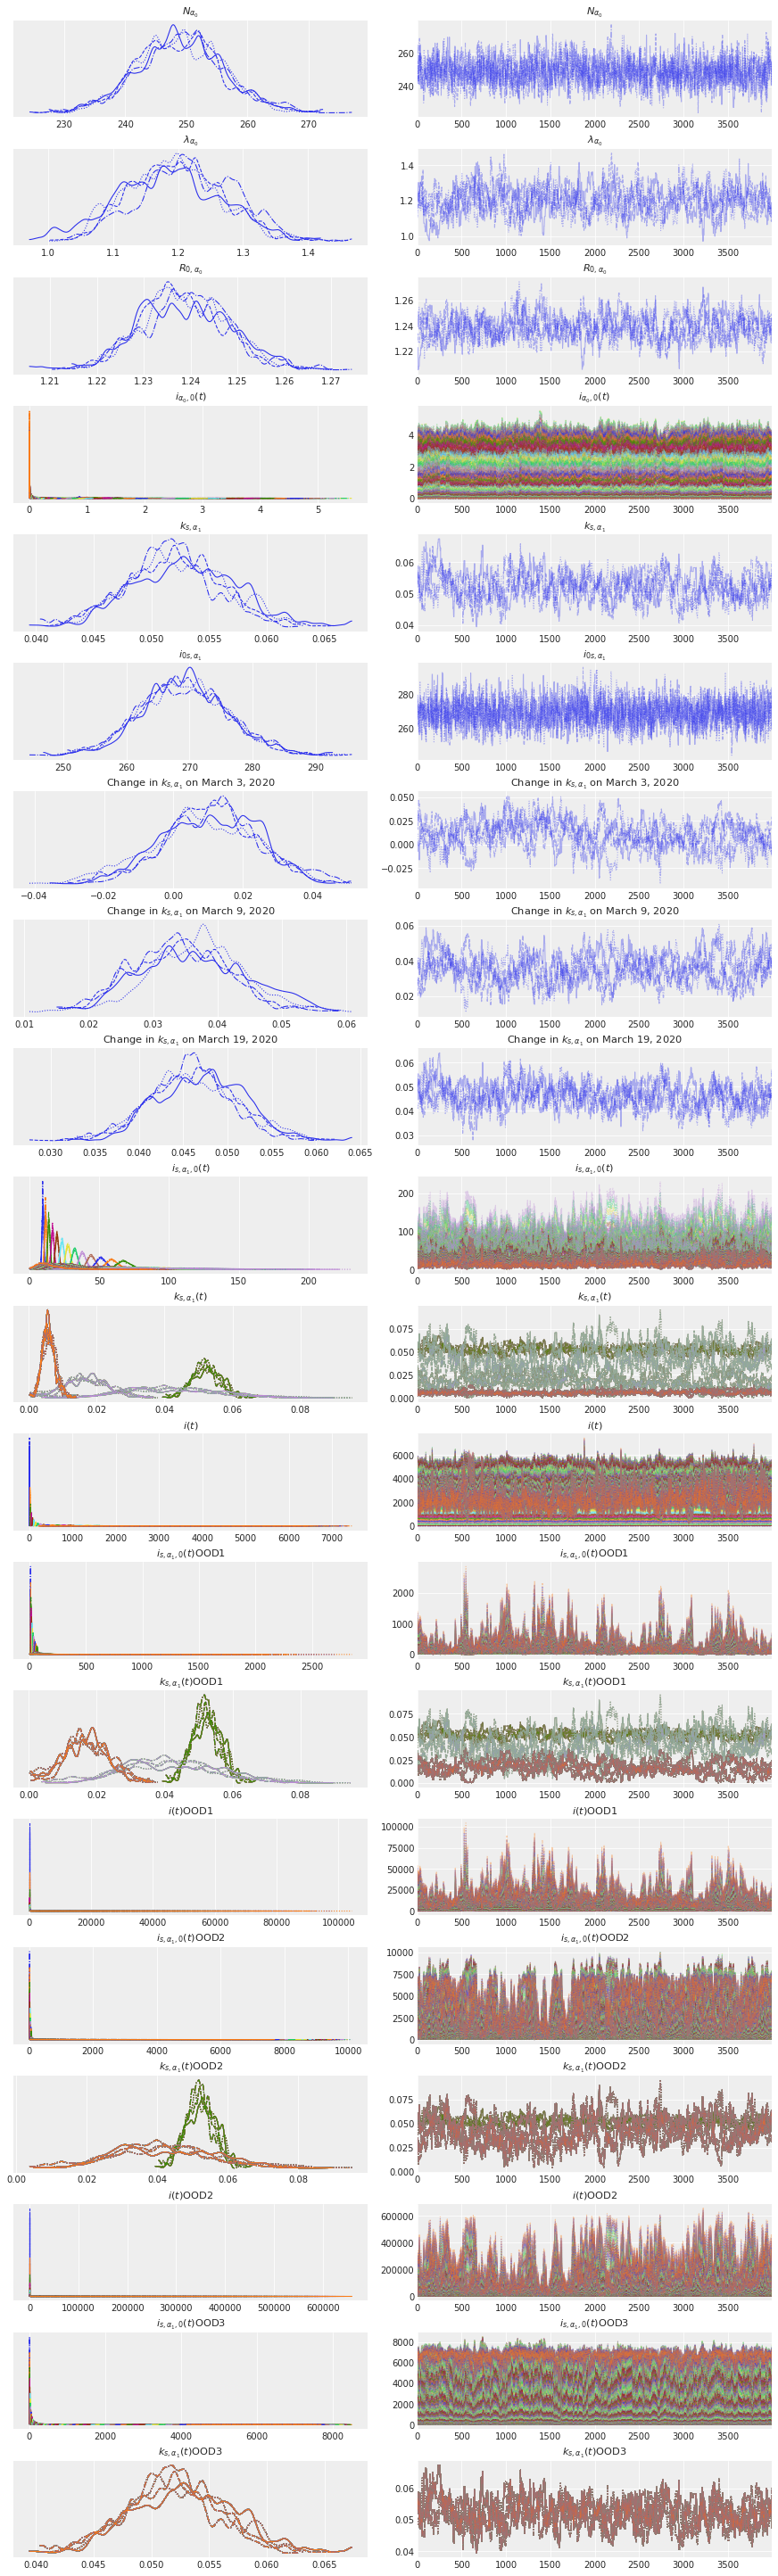

In [10]:
az.plot_trace(trace)
plt.show()

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$N_{\alpha_{0}}$,249.042,7.068,235.747,262.694,0.195,0.138,1319.0,1889.0,1.00
$\lambda_{\alpha_{0}}$,1.198,0.075,1.063,1.335,0.005,0.004,196.0,281.0,1.03
"$R_{0,\alpha_{0}}$",1.239,0.009,1.221,1.255,0.001,0.000,338.0,618.0,1.01
"$i_{\alpha_{0},0}(t)$[0]",0.860,0.027,0.811,0.911,0.002,0.001,185.0,266.0,1.03
"$i_{\alpha_{0},0}(t)$[1]",0.997,0.036,0.928,1.064,0.003,0.002,182.0,291.0,1.03
...,...,...,...,...,...,...,...,...,...
Forecast[13],2348.260,807.451,955.908,3921.333,59.151,41.892,191.0,532.0,1.04
Forecast[14],2293.197,819.858,884.126,3888.172,60.280,42.692,189.0,523.0,1.04
Forecast[15],2239.494,831.668,825.813,3861.782,61.367,43.462,188.0,520.0,1.04
Forecast[16],2187.139,842.974,769.036,3832.582,62.417,44.206,187.0,502.0,1.04


E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (963) in plot_posterior, generating only 40 plots
  warnings.warn(


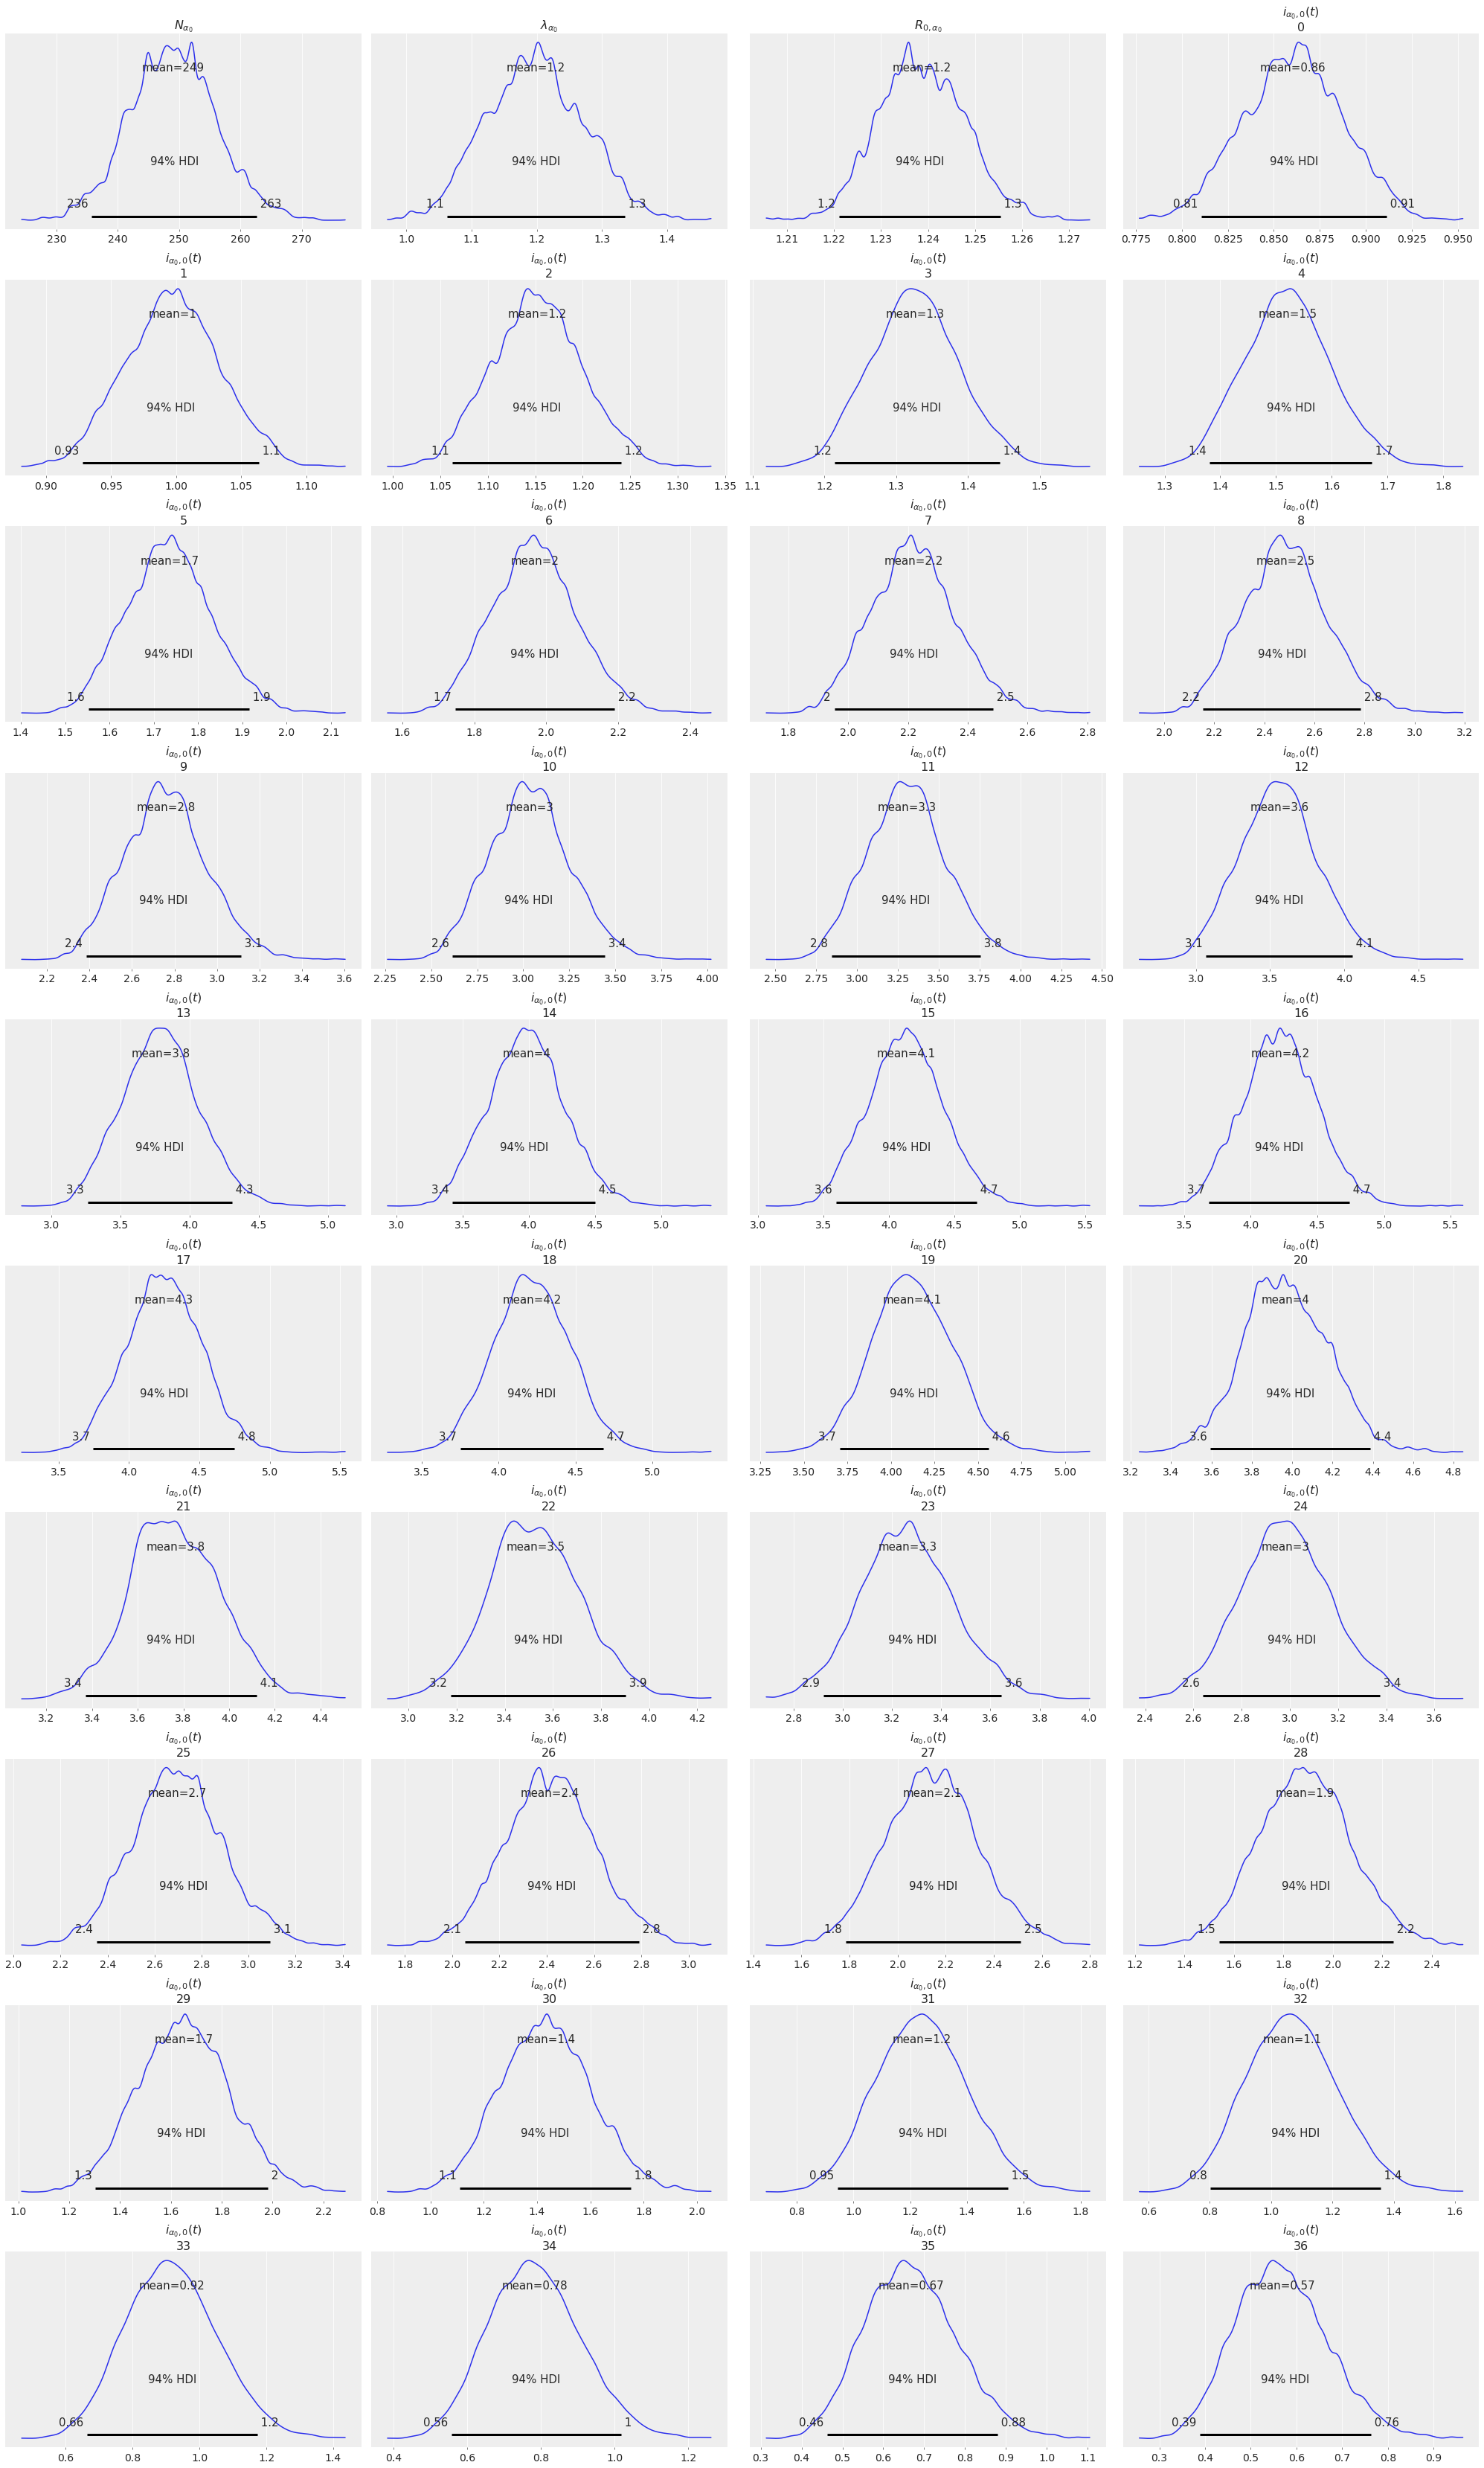

In [12]:
az.plot_posterior(trace)
plt.show()

In [13]:
with model:
    pp = pm.sample_posterior_predictive(trace, samples=1000, \
                                        var_names=["Fit", "Forecast", r'$i(t)$OOD1', r'$i(t)$OOD2', r'$i(t)$OOD3', \
                                                   r'$\varepsilon_{i(t)}$', r"$k_{s,\alpha_{1}}(t)$", \
                                                   r"$k_{s,\alpha_{1}}(t)$OOD1", r"$k_{s,\alpha_{1}}(t)$OOD2", \
                                                   r"$k_{s,\alpha_{1}}(t)$OOD3"])
    pp_fit = pp["Fit"]
    dtm_forecast = pp["Forecast"]
    dtm_ood1 = pp[r'$i(t)$OOD1']
    dtm_ood2 = pp[r'$i(t)$OOD2']
    dtm_ood3 = pp[r'$i(t)$OOD3']
    pp_eps = pp[r'$\varepsilon_{i(t)}$']
    pp_k1t = pp[r"$k_{s,\alpha_{1}}(t)$"]
    pp_k1t_ood1 = pp[r"$k_{s,\alpha_{1}}(t)$OOD1"]
    pp_k1t_ood2 = pp[r"$k_{s,\alpha_{1}}(t)$OOD2"]
    pp_k1t_ood3 = pp[r"$k_{s,\alpha_{1}}(t)$OOD3"]
    pass

E:\anaconda3\envs\covid19bayes\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [14]:
pp_forecast = pm.Normal.dist(mu=dtm_forecast, sigma=dtm_forecast*pp_eps.reshape((pp_eps.shape[0], 1))).random()
pp_ood1 = pm.Normal.dist(mu=dtm_ood1, sigma=dtm_ood1*pp_eps.reshape((pp_eps.shape[0], 1))).random()
pp_ood2 = pm.Normal.dist(mu=dtm_ood2, sigma=dtm_ood2*pp_eps.reshape((pp_eps.shape[0], 1))).random()
pp_ood3 = pm.Normal.dist(mu=dtm_ood3, sigma=dtm_ood3*pp_eps.reshape((pp_eps.shape[0], 1))).random()

E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


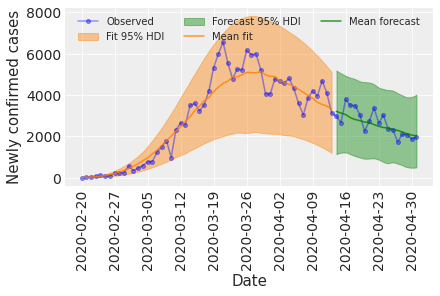

In [15]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
    
ax.plot(np.arange(len(Id_covid19_series)), Id_covid19_series, "o-", ms=4, \
        color="blue", alpha=0.4, label="Observed")
az.plot_hdi(np.arange(fit_ndays), pp_fit, hdi_prob=0.95, \
            color="#FF7F00", fill_kwargs={"alpha": 0.4, "label": "Fit 95% HDI"})
az.plot_hdi(np.arange(fit_ndays, len(Id_covid19_series)), pp_forecast, hdi_prob=0.95, \
            color="green", fill_kwargs={"alpha": 0.4, "label": "Forecast 95% HDI"})
ax.plot(np.arange(fit_ndays), pp_fit.mean(0), color="#FF7F00", alpha=0.8, label="Mean fit")
ax.plot(np.arange(fit_ndays, len(Id_covid19_series)), pp_forecast.mean(0), color="green", \
        alpha=0.8, label="Mean forecast")

x_day_interval = max(1, (len(d.dates)) // 10)
plt.xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
plt.xlabel("Date")
plt.ylabel("Newly confirmed cases")
ax.legend(ncol=3, fontsize=10, loc="upper center")
plt.show()

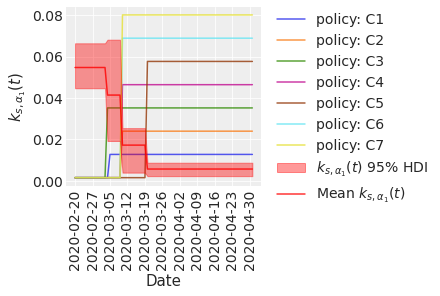

In [16]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

rmax = np.max(np.array(pp_k1t))
rmin = np.min(np.array(pp_k1t))
n_policy_valid = np.sum((np.sum(np.array(d.policy_series), axis=0)>0).astype(int))
j = 0
for i, p in enumerate(d._DataReader__policy_reader.PolicyType):
    if np.sum(np.array(d.policy_series)[:, i]) > 0:
        j += 1
        plt.plot((rmax-rmin)*np.array(d.policy_series)[:, i]*j/(1.0*n_policy_valid)+rmin, \
                 alpha=0.8, label="policy: "+p, zorder=0.8)
        pass
    pass
az.plot_hdi(np.arange(len(Id_covid19_series)), pp_k1t, hdi_prob=0.95, smooth=False, \
                  color="red", fill_kwargs={"alpha": 0.4, "label": r"$k_{s,\alpha_{1}}(t)$ 95% HDI"})
ax.plot(np.arange(len(Id_covid19_series)), pp_k1t.mean(0), color="red", \
        alpha=0.8, label=r"Mean $k_{s,\alpha_{1}}(t)$")
x_day_interval = max(1, (len(d.dates)) // 10)
plt.xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
plt.xlabel("Date")
plt.ylabel(r"$k_{s,\alpha_{1}}(t)$")
plt.legend(bbox_to_anchor=(1.05, 1.0), borderaxespad=0)
plt.show()

C:\Users\wmy\AppData\Local\Temp\ipykernel_2964\3195913112.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.arange(len(Id_covid19_series)), np.log10(Id_covid19_series), "o-", ms=4, \


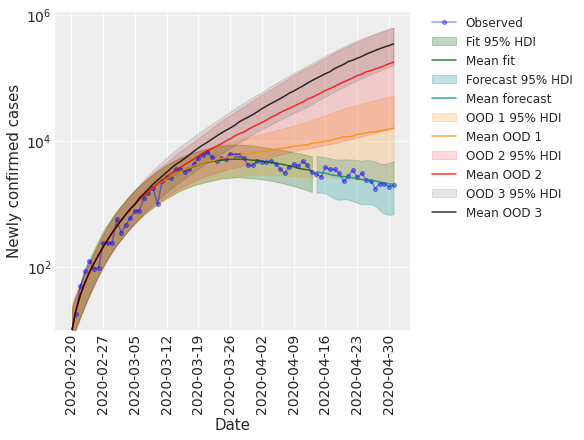

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')

ax.plot(np.arange(len(Id_covid19_series)), np.log10(Id_covid19_series), "o-", ms=4, \
        color="blue", alpha=0.4, label="Observed")
    
az.plot_hdi(np.arange(fit_ndays), np.log10(np.maximum(1, pp_fit)), hdi_prob=0.95, \
            color="darkgreen", fill_kwargs={"alpha": 0.25, "label": "Fit 95% HDI"})
ax.plot(np.arange(fit_ndays), np.log10(pp_fit.mean(0)), color="darkgreen", alpha=0.8, label="Mean fit")

az.plot_hdi(np.arange(fit_ndays, len(Id_covid19_series)), np.log10(np.maximum(1, pp_forecast)), hdi_prob=0.95, \
            color="darkcyan", fill_kwargs={"alpha": 0.25, "label": "Forecast 95% HDI"})
ax.plot(np.arange(fit_ndays, len(Id_covid19_series)), np.log10(pp_forecast.mean(0)), color="darkcyan", \
        alpha=0.8, label="Mean forecast")

az.plot_hdi(np.arange(len(Id_covid19_series)), np.log10(np.maximum(1, pp_ood1)), hdi_prob=0.95, \
            color="darkorange", fill_kwargs={"alpha": 0.2, "label": "OOD 1 95% HDI"})
ax.plot(np.arange(len(Id_covid19_series)), np.log10(pp_ood1.mean(0)), color="darkorange", \
        alpha=0.8, label="Mean OOD 1")

az.plot_hdi(np.arange(len(Id_covid19_series)), np.log10(np.maximum(1, pp_ood2)), hdi_prob=0.95, \
            color="red", fill_kwargs={"alpha": 0.15, "label": "OOD 2 95% HDI"})
ax.plot(np.arange(len(Id_covid19_series)), np.log10(pp_ood2.mean(0)), color="red", \
        alpha=0.8, label="Mean OOD 2")

az.plot_hdi(np.arange(len(Id_covid19_series)), np.log10(np.maximum(1, pp_ood3)), hdi_prob=0.95, \
            color="black", fill_kwargs={"alpha": 0.1, "label": "OOD 3 95% HDI"})
ax.plot(np.arange(len(Id_covid19_series)), np.log10(pp_ood3.mean(0)), color="black", \
        alpha=0.8, label="Mean OOD 3")

x_day_interval = max(1, (len(d.dates)) // 10)
plt.xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
plt.xlabel("Date")
plt.ylabel("Newly confirmed cases")
yticks = [r"$10^{}$".format(int(x)) for x in ax.get_yticks()[::2]]
plt.yticks(list(range(0, len(ax.get_yticks()), 2)), yticks)
plt.ylim(bottom=1)
ax.legend(bbox_to_anchor=(1.05, 1.0), borderaxespad=0, fontsize=12)
plt.show()

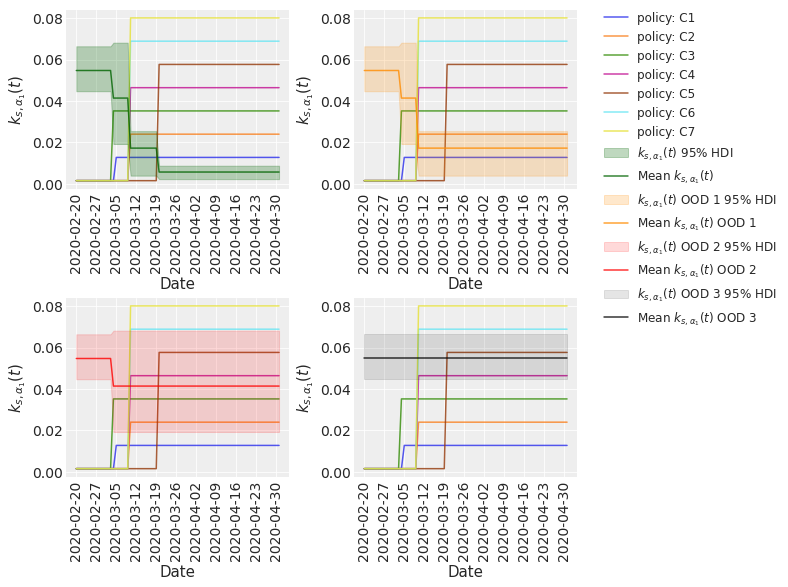

In [18]:
fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor('white')

gs = fig.add_gridspec(2, 2)
ax_origin = fig.add_subplot(gs[0, 0])
ax_ood1 = fig.add_subplot(gs[0, 1])
ax_ood2 = fig.add_subplot(gs[1, 0])
ax_ood3 = fig.add_subplot(gs[1, 1])

ax = ax_origin
rmax = np.max(np.array(pp_k1t))
rmin = np.min(np.array(pp_k1t))
n_policy_valid = np.sum((np.sum(np.array(d.policy_series), axis=0)>0).astype(int))
j = 0
for i, p in enumerate(d._DataReader__policy_reader.PolicyType):
    if np.sum(np.array(d.policy_series)[:, i]) > 0:
        j += 1
        ax.plot((rmax-rmin)*np.array(d.policy_series)[:, i]*j/(1.0*n_policy_valid)+rmin, \
                alpha=0.8, label="policy: "+p, zorder=0.8)
        pass
    pass
    
az.plot_hdi(np.arange(len(Id_covid19_series)), pp_k1t, hdi_prob=0.95, smooth=False, ax=ax, \
                  color="darkgreen", fill_kwargs={"alpha": 0.25, "label": r"$k_{s,\alpha_{1}}(t)$ 95% HDI"})
ax.plot(np.arange(len(Id_covid19_series)), pp_k1t.mean(0), color="darkgreen", \
        alpha=0.8, label=r"Mean $k_{s,\alpha_{1}}(t)$")

x_day_interval = max(1, (len(d.dates)) // 10)
ax.set_xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
ax.set_xlabel("Date")
ax.set_ylabel(r"$k_{s,\alpha_{1}}(t)$")

ax = ax_ood1
rmax = np.max(np.array(pp_k1t))
rmin = np.min(np.array(pp_k1t))
n_policy_valid = np.sum((np.sum(np.array(d.policy_series), axis=0)>0).astype(int))
j = 0
for i, p in enumerate(d._DataReader__policy_reader.PolicyType):
    if np.sum(np.array(d.policy_series)[:, i]) > 0:
        j += 1
        ax.plot((rmax-rmin)*np.array(d.policy_series)[:, i]*j/(1.0*n_policy_valid)+rmin, \
                alpha=0.8, label="policy: "+p, zorder=0.8)
        pass
    pass

az.plot_hdi(np.arange(len(Id_covid19_series)), pp_k1t_ood1, hdi_prob=0.95, smooth=False, ax=ax, \
            color="darkorange", fill_kwargs={"alpha": 0.2, "label": r"$k_{s,\alpha_{1}}(t)$ OOD 1 95% HDI"})
ax.plot(np.arange(len(Id_covid19_series)), pp_k1t_ood1.mean(0), color="darkorange", \
        alpha=0.8, label=r"Mean $k_{s,\alpha_{1}}(t)$ OOD 1")

x_day_interval = max(1, (len(d.dates)) // 10)
ax.set_xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
ax.set_xlabel("Date")
ax.set_ylabel(r"$k_{s,\alpha_{1}}(t)$")

ax = ax_ood2
rmax = np.max(np.array(pp_k1t))
rmin = np.min(np.array(pp_k1t))
n_policy_valid = np.sum((np.sum(np.array(d.policy_series), axis=0)>0).astype(int))
j = 0
for i, p in enumerate(d._DataReader__policy_reader.PolicyType):
    if np.sum(np.array(d.policy_series)[:, i]) > 0:
        j += 1
        ax.plot((rmax-rmin)*np.array(d.policy_series)[:, i]*j/(1.0*n_policy_valid)+rmin, \
                alpha=0.8, label="policy: "+p, zorder=0.8)
        pass
    pass

az.plot_hdi(np.arange(len(Id_covid19_series)), pp_k1t_ood2, hdi_prob=0.95, smooth=False, ax=ax, \
            color="red", fill_kwargs={"alpha": 0.15, "label": r"$k_{s,\alpha_{1}}(t)$ OOD 2 95% HDI"})
ax.plot(np.arange(len(Id_covid19_series)), pp_k1t_ood2.mean(0), color="red", \
        alpha=0.8, label=r"Mean $k_{s,\alpha_{1}}(t)$ OOD 2")

x_day_interval = max(1, (len(d.dates)) // 10)
ax.set_xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
ax.set_xlabel("Date")
ax.set_ylabel(r"$k_{s,\alpha_{1}}(t)$")

ax = ax_ood3
rmax = np.max(np.array(pp_k1t))
rmin = np.min(np.array(pp_k1t))
n_policy_valid = np.sum((np.sum(np.array(d.policy_series), axis=0)>0).astype(int))
j = 0
for i, p in enumerate(d._DataReader__policy_reader.PolicyType):
    if np.sum(np.array(d.policy_series)[:, i]) > 0:
        j += 1
        ax.plot((rmax-rmin)*np.array(d.policy_series)[:, i]*j/(1.0*n_policy_valid)+rmin, \
                alpha=0.8, label="policy: "+p, zorder=0.8)
        pass
    pass

az.plot_hdi(np.arange(len(Id_covid19_series)), pp_k1t_ood3, hdi_prob=0.95, smooth=False, ax=ax, \
            color="black", fill_kwargs={"alpha": 0.1, "label": r"$k_{s,\alpha_{1}}(t)$ OOD 3 95% HDI"})
ax.plot(np.arange(len(Id_covid19_series)), pp_k1t_ood3.mean(0), color="black", \
        alpha=0.8, label=r"Mean $k_{s,\alpha_{1}}(t)$ OOD 3")

x_day_interval = max(1, (len(d.dates)) // 10)
ax.set_xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
ax.set_xlabel("Date")
ax.set_ylabel(r"$k_{s,\alpha_{1}}(t)$")

handles, labels = [], []

for i in range(len(fig.axes)):
    handles_, labels_ = fig.axes[i].get_legend_handles_labels()
    for j in range(len(labels_)):
        if labels_[j] not in labels:
            handles.append(handles_[j])
            labels.append(labels_[j])
            pass
        pass
    pass

fig.legend(handles, labels, bbox_to_anchor=(1.35, 1.0), borderaxespad=0, fontsize=12)

plt.show()

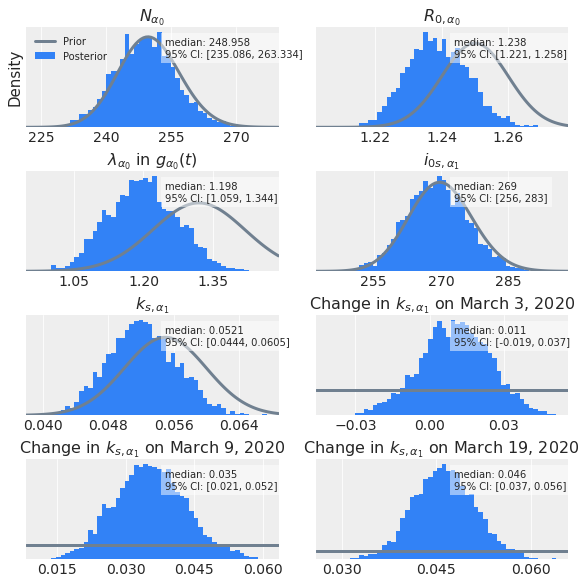

In [19]:
fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor('white')

gs = fig.add_gridspec(4, 2)

ax_N_alpha0 = fig.add_subplot(gs[0, 0])
ax_R0_alpha0 = fig.add_subplot(gs[0, 1])
ax_lambda_alpha0 = fig.add_subplot(gs[1, 0])
ax_i0s_alpha1 = fig.add_subplot(gs[1, 1])
ax_ks_alpha1 = fig.add_subplot(gs[2, 0])
ax_R0_alpha0_change_1 = fig.add_subplot(gs[2, 1])
ax_R0_alpha0_change_2 = fig.add_subplot(gs[3, 0])
ax_R0_alpha0_change_3 = fig.add_subplot(gs[3, 1])

ax = ax_N_alpha0
posterior = np.array(trace.posterior[r'$N_{\alpha_{0}}$']).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
mu, sigma = LogNormalParams(250, 50)
ax.plot(x, scipy.stats.lognorm.pdf(x, loc=0, s=sigma, scale=np.exp(mu)), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r'$N_{\alpha_{0}}$')
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('Density')
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 3)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 3)
ci_right = truncate_number(ci_right, 3)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[::-1], ncol=1, fontsize=10, loc="upper left")

ax = ax_R0_alpha0
posterior = np.array(trace.posterior[r"$R_{0,\alpha_{0}}$"]).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=1.25, scale=0.01), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r"$R_{0,\alpha_{0}}$")
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 3)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 3)
ci_right = truncate_number(ci_right, 3)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

ax = ax_lambda_alpha0
posterior = np.array(trace.posterior[r'$\lambda_{\alpha_{0}}$']).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=1.32, scale=0.1), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r'$\lambda_{\alpha_{0}}$ in $g_{\alpha_{0}}(t)$')
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 3)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 3)
ci_right = truncate_number(ci_right, 3)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

ax = ax_i0s_alpha1
posterior = np.array(trace.posterior[r"$i_{0s,\alpha_{1}}$"]).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
mu, sigma = LogNormalParams(270, 50)
ax.plot(x, scipy.stats.lognorm.pdf(x, loc=0, s=sigma, scale=np.exp(mu)), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r"$i_{0s,\alpha_{1}}$")
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 0)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 0)
ci_right = truncate_number(ci_right, 0)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

ax = ax_ks_alpha1
posterior = np.array(trace.posterior[r"$k_{s,\alpha_{1}}$"]).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=0.055, scale=0.005), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r"$k_{s,\alpha_{1}}$")
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 4)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 4)
ci_right = truncate_number(ci_right, 4)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

ax = ax_R0_alpha0_change_1
posterior = np.array(trace.posterior[r"Change in $k_{s,\alpha_{1}}$ on March 3, 2020"]).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.uniform.pdf(x, loc=-0.05, scale=0.05+np.max(pp_k1t)), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r"Change in $k_{s,\alpha_{1}}$ on March 3, 2020")
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 3)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 3)
ci_right = truncate_number(ci_right, 3)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

ax = ax_R0_alpha0_change_2
posterior = np.array(trace.posterior[r"Change in $k_{s,\alpha_{1}}$ on March 9, 2020"]).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.uniform.pdf(x, loc=-0.05, scale=0.05+np.max(pp_k1t)), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r"Change in $k_{s,\alpha_{1}}$ on March 9, 2020")
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 3)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 3)
ci_right = truncate_number(ci_right, 3)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

ax = ax_R0_alpha0_change_3
posterior = np.array(trace.posterior[r"Change in $k_{s,\alpha_{1}}$ on March 19, 2020"]).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.uniform.pdf(x, loc=-0.05, scale=0.05+np.max(pp_k1t)), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r"Change in $k_{s,\alpha_{1}}$ on March 19, 2020")
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 3)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 3)
ci_right = truncate_number(ci_right, 3)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

plt.show()

E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\plots\pairplot.py:242: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


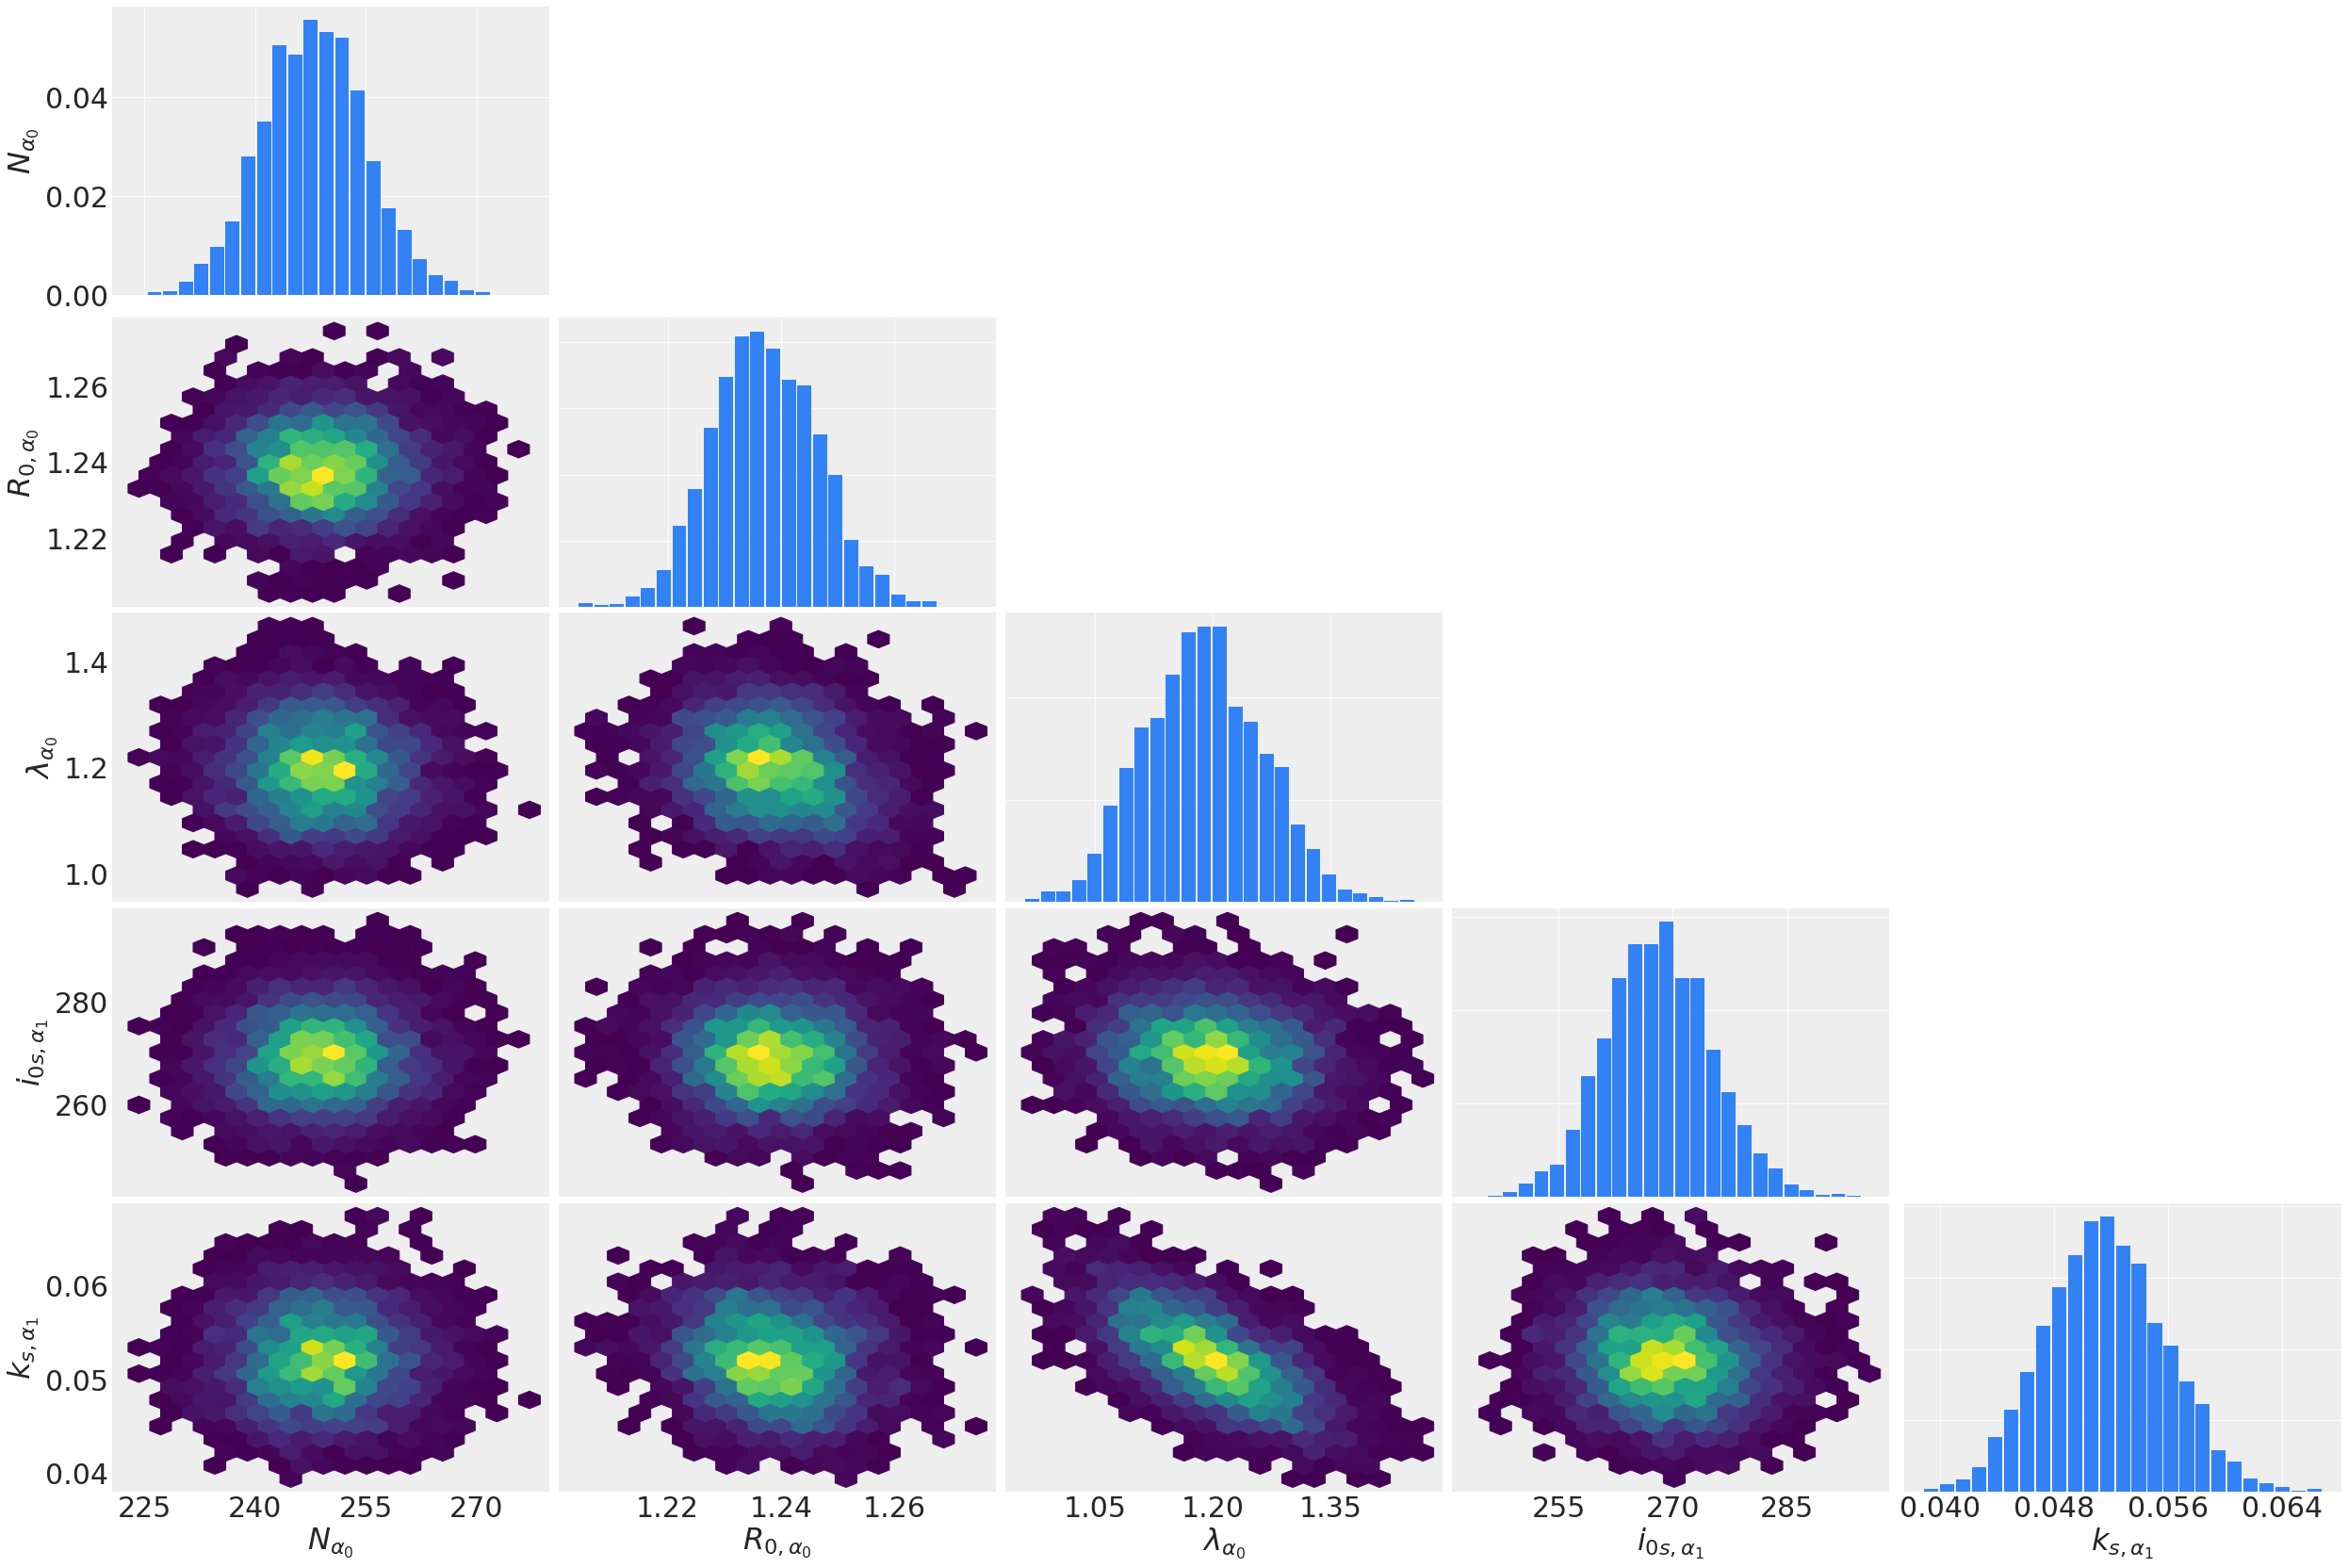

In [20]:
subplots = az.plot_pair(
    trace,
    var_names = [r'$N_{\alpha_{0}}$', \
                 r"$R_{0,\alpha_{0}}$", \
                 r'$\lambda_{\alpha_{0}}$', \
                 r"$i_{0s,\alpha_{1}}$", \
                 r"$k_{s,\alpha_{1}}$"],
    kind = "hexbin",
    divergences = True,
    textsize = 30,
    marginals = True,
    marginal_kwargs = {"kind": "hist", "hist_kwargs": {"bins": 25, "density": True, "color": "#3282F6"}}
).tolist()

for i in range(len(subplots)):
    for j in range(len(subplots[0])):
        ax = subplots[i][j]
        if type(ax.axes) != type(None):
            ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
            pass
        pass
    pass

plt.show()

In [21]:
model_loo = az.loo(trace, model, var_name=r'Fit')
print(model_loo.loo)
print(model_loo.p_loo)

E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\stats\stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
E:\anaconda3\envs\covid19bayes\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


-405.49584869630587
4.931369731519794


In [22]:
model_waic = az.waic(trace, model, var_name=r'Fit')
print(model_waic.waic)
print(model_waic.p_waic)

-405.3969262172451
4.8324472524591116


E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
